In [1]:
import glob
import pandas as pd
import os
import numpy as np

# dir = "/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data"
# files = glob.glob(dir + '/*_eakf_metrics.csv')

dir = "/ifs/scratch/jls106_gp/nhw2114/data/20231106_synthetic_data"
files = glob.glob(dir + '/*_eakf_metrics.csv')
print(len(files))

47871


In [2]:
df = pd.DataFrame(files, columns=['filepath'])
print(df.shape)

(47871, 1)


In [3]:
dfs = []
for file in files:
    df = pd.read_csv(file)
    param = os.path.basename(file).split("_")[0]
    df["param"] = param
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=False)
# combined_df.to_csv(f"{dir}/eakf_metrics_all.csv", index=False)

In [10]:
combined_df[["method", 'rt_peak_rmse', 'rt_rmse', 'data_rmse', 'avg_w2', 'avg_kl',
       'in_ci', 'ens_var', 'in_ci_last_day', 'ens_var_last_day']].groupby("method").mean()

,rt_peak_rmse,rt_rmse,data_rmse,avg_w2,avg_kl,in_ci,ens_var,in_ci_last_day,ens_var_last_day
method,,,,,,,,,
adaptive inflation,0.084826,0.374294,47.155028,0.642215,0.952634,0.662688,0.019103,0.974248,0.020679
fixed inflation,0.044096,0.599342,68.934736,0.811221,3.306925,0.172926,0.005275,0.431954,0.001028
no inflation,0.024712,1.763016,117.320117,0.988785,7.159076,0.000000,0.000009,0.000000,0.000009
smooth,0.043555,0.253315,58.498542,0.384004,0.968655,0.543373,0.004541,0.971483,0.019151


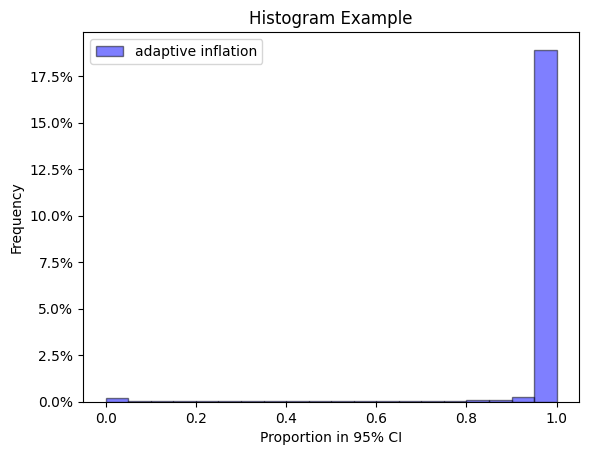

In [39]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


fig = plt.figure()
ax = fig.add_subplot(111)
# ax.hist(combined_df.loc[combined_df["method"] == "fixed inflation", "in_ci_last_day"], bins=20, color='yellow', label="fixed inflation", edgecolor='black', alpha=0.5, density=True)
ax.hist(combined_df.loc[combined_df["method"] == "adaptive inflation", "in_ci_last_day"], bins=20, color='blue', label="adaptive inflation", edgecolor='black', alpha=0.5, density=True) 
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
plt.title('Histogram Example')
plt.xlabel('Proportion in 95% CI')
plt.ylabel('Frequency')
plt.legend()

In [28]:
check_params = combined_df.loc[(combined_df["method"] == "adaptive inflation") & (combined_df["in_ci_last_day"] == 0), "param"]
print(len(check_params))
pdfs = [f"{dir}/{param_num}_eakf_posterior_adaptive_inflation.pdf" for param_num in check_params]

197


In [29]:
from pypdf import PdfMerger

merger = PdfMerger()

for pdf in pdfs:
    merger.append(pdf)

merger.write("merge.pdf")
merger.close()

# COMPUTE LAST DAY, PEAKS, DATA DISTRIBUTION, AND 

In [11]:
import pickle
from epyfilter import simulate_data
from tqdm import tqdm

good_param_df = pd.read_csv("good_param_list.csv")
pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in good_param_df.param]

def compute_late_day(data):
    beta_1 = data.rt_1 / data.t_I
    beta_0 = data.rt_0 / data.t_I
    late_day = -1/data.k * np.log((beta_1 - beta_0)/(0.99*beta_1 - beta_0)-1) + data.midpoint
    late_day = int(late_day)
    return late_day

def compute_peaks(data):
    det_data = simulate_data.simulate_data(**data.true_params, run_deterministic=True)
    peak_days, = np.where(np.diff(np.sign(np.diff(det_data.i_true))) == -2)  # days where it increases before then decreases
    peak_days = peak_days[:2]  # just take first two days
    return peak_days

def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

In [30]:
data_files = glob.glob(dir + '/*_data_distribution.csv')
done_params = [int(os.path.basename(f).split("_")[0]) for f in data_files]
todo_params = list(set(good_param_df.param) - set(done_params))

pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in todo_params]

In [31]:
for pp in tqdm(pickle_list):
    param = os.path.basename(pp).split("_")[0]
    data = open_pickle(pp)
    data_distribution_df = pd.DataFrame(data.data_distribution, columns=[f"sample{x}" for x in range(1,301)])
    data_distribution_df["day"] = range(len(data_distribution_df))
    data_distribution_df["late_day"] = compute_late_day(data)
    peaks = compute_peaks(data)
    data_distribution_df["peak1"] = peaks[0]
    data_distribution_df["peak2"] = peaks[1]
    
    data_distribution_df.to_csv(f"{dir}/{param}_data_distribution.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 29529/29529 [2:54:39<00:00,  2.82it/s]


In [32]:
data_files = glob.glob(dir + '/*_data_distribution.csv')

In [33]:
len(data_files)

47871

In [34]:
good_param_df.shape

(47871, 1)

# Fix Single Epidemics

In [7]:
pickles = glob.glob(dir + '/*.pkl')

In [8]:
import pickle
def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100185/100185 [3:04:18<00:00,  9.06it/s]


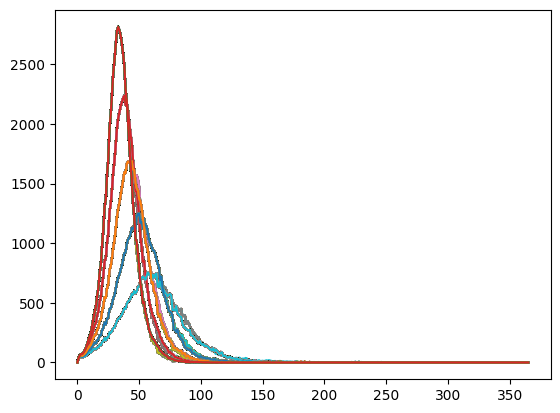

In [10]:
from tqdm import tqdm
from scipy.signal import find_peaks

bad_params = []
for file in tqdm(pickles):
    data = open_pickle(file)

    window_size = 10  # Adjust this window size as needed
    smoothed_data = np.convolve(data.i_true, np.ones(window_size) / window_size, mode='valid')
    peaks, _ = find_peaks(smoothed_data, height=100, prominence=10)
    if len(peaks) < 2:
        bad_params.append(file)
        plt.plot(data.i_true)

In [11]:
len(bad_params)

52314

In [14]:
pd.DataFrame(bad_params).to_csv("one_epidemic_curve.csv", index=False)

In [18]:
bad_metric_files = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{os.path.basename(b).split('_')[0]}_eakf_metrics.csv" for b in bad_params]

In [21]:
dfs = []
for file in tqdm(files):
    if file not in bad_metric_files:
        df = pd.read_csv(file)
        param = os.path.basename(file).split("_")[0]
        df["param"] = param
        dfs.append(df)

good_combined_df = pd.concat(dfs, ignore_index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100185/100185 [07:22<00:00, 226.36it/s]


In [22]:
good_combined_df[["method", "rt_peak_rmse", "rt_rmse", "data_rmse", "avg_w2", "avg_kl", "in_ci"]].groupby("method").mean()

,rt_peak_rmse,rt_rmse,data_rmse,avg_w2,avg_kl,in_ci
method,,,,,,
adaptive inflation,0.084815,0.374231,47.154245,0.642203,0.952536,0.662593
fixed inflation,0.044096,0.599377,68.936821,0.811197,3.306851,0.172927
no inflation,0.024710,1.763012,117.320087,0.988873,7.159461,0.000000
smooth,0.043557,0.253248,58.496632,0.383990,0.968416,0.543410


Text(0, 0.5, 'Count')

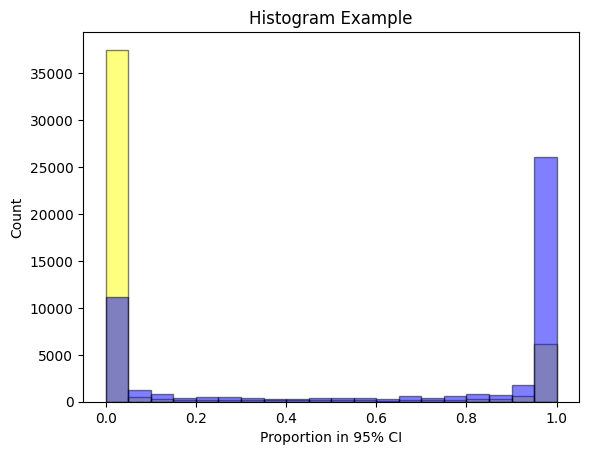

In [23]:
plt.hist(good_combined_df.loc[good_combined_df["method"] == "fixed inflation", "in_ci"], bins=20, color='yellow', edgecolor='black', alpha=0.5)
plt.hist(good_combined_df.loc[good_combined_df["method"] == "adaptive inflation", "in_ci"], bins=20, color='blue', edgecolor='black', alpha=0.5)
plt.title('Histogram Example')
plt.xlabel('Proportion in 95% CI')
plt.ylabel('Count')

In [42]:
pd.DataFrame(good_combined_df.param.unique(), columns=["param"]).to_csv("good_param_list.csv", index=False)

In [45]:
df = pd.read_csv("good_param_list.csv")
pickle_files = df.iloc[1:1000, 0]

In [46]:
pickle_files = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{p}_synthetic_data.pkl" for p in pickle_files]

In [51]:
4788/200 * 3

71.82000000000001

In [55]:
files = glob.glob(dir + '/*_for_epiestim.csv')

In [58]:
pd.read_csv(files[0])

,rt,i,prop_S
0,1.3,33.742320,0.99869
1,1.3,42.500996,0.99826
2,1.3,45.972273,0.99778
3,1.3,38.297496,0.99736
4,1.3,38.854358,0.99690
...,...,...,...
360,4.7,0.000000,0.58860
361,4.7,0.396479,0.58860
362,4.7,0.000000,0.58860
363,4.7,0.000000,0.58860
